In [2]:
TRAIN_MODE = True

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import multiprocessing
from pandarallel import pandarallel

In [3]:
# To use all available CPUs
n_cpus = multiprocessing.cpu_count()
print('CPUs available: ', n_cpus)
pandarallel.initialize(progress_bar=True, nb_workers=n_cpus)

CPUs available:  8
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
def get_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    return device

device = get_device()

Using cpu device


In [5]:
class CFG:
    # Data
    BASE_DIR = "../contrails-kaggle-files/"
    TRAIN_DIR = BASE_DIR + "train/"
    VALIDATION_DIR = BASE_DIR + "validation/"

    
    # Train
    num_epochs = 20
    batch_size = 1
    num_workers = multiprocessing.cpu_count()
    
    # Optimizer
    lr = 0.0001

In [6]:
os.listdir('../contrails-kaggle-files/')

['sample_submission.csv',
 'train_metadata.json',
 'validation_pedro_metadata.json',
 'train',
 'validation',
 '.ipynb_checkpoints',
 'src',
 'validation_metadata.json_original',
 'test']

In [7]:
# Sample normalization code
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def normalize_std(spec):
    return (spec- np.mean(spec))/np.std(spec)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, mode='train'):
        self.data_path = data_path
        self.file_name = os.listdir(data_path)
        self.mode = mode
        

    def __len__(self):
        return len(self.file_name)

    def __getitem__(self, i):
        

        ash = np.load(self.data_path + self.file_name[i] + '/ash_image.npy')
        # extra_band = normalize_band(band_14)

        # band_14 = np.load(self.data_path + self.file_name[i] + '/band_14.npy')
        # # band_14= band_14/np.linalg.norm(band_14)
        # band_15 = np.load(self.data_path + self.file_name[i] + '/band_15.npy')
        

        
        # r = normalize_range(band_15 - band_14, _TDIFF_BOUNDS)
        # g = normalize_range(band_14 - band_11, _CLOUD_TOP_TDIFF_BOUNDS)
        # b = normalize_range(band_14, _T11_BOUNDS)
        x = np.transpose(ash[:,:,:,4],(2,0,1))
        x = normalize_std(x)
        
        if self.mode == 'train':
            # with bucket.blob(self.data_path + self.file_name[i] + '/human_pixel_masks.npy').open("rb") as f:
            y = np.load(self.data_path + self.file_name[i] + '/human_pixel_masks.npy').astype(np.float32).transpose(2,0,1)
        elif self.mode == 'test':
            y = self.file_name[i]
        else:
            y = None
        
        return x, y

In [8]:
CFG.TRAIN_DIR

'../contrails-kaggle-files/train/'

In [9]:

base_path = '../contrails-kaggle-files/'
train_path = base_path + 'train/'
test_path = base_path + 'test/'
record_id = '8070893861055857193'
validation_files_df = pd.DataFrame(os.listdir(base_path + 'validation'), columns=['record_id'])
train_metadata_df = pd.read_json(base_path+ "train_metadata.json")

In [10]:
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size
num_workers = CFG.num_workers

train_dataset = Dataset(CFG.TRAIN_DIR)
validation_dataset = Dataset(CFG.VALIDATION_DIR)



In [10]:
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = self.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
dice = Dice()

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False, num_classes=1)
model.to(device);

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
criterion = nn.BCEWithLogitsLoss()

m = nn.Sigmoid()

Using cache found in /home/jupyter/.cache/torch/hub/pytorch_vision_v0.10.0


In [98]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True, pin_memory=True)


In [13]:
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    train_dice, val_dice = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for i_train, (X, y) in enumerate(tqdm(train_loader)):   
        n_train += len(y)
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(X)['out']
        loss = criterion(torch.flatten(pred), torch.flatten(y))
        dice_temp = dice(torch.flatten(pred), torch.flatten(y))

        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        train_dice += dice_temp.item()

    model.eval()
    with torch.no_grad():
        for i_val, (X, y) in enumerate(validation_loader):   
            n_val += len(y)
            X = X.to(device)
            y = y.to(device)

            pred = model(X)['out']
            loss = criterion(torch.flatten(pred), torch.flatten(y))
            dice_temp = dice(torch.flatten(pred), torch.flatten(y))

            val_loss += loss.item()
            val_dice += dice_temp.item()

    print (f'Epoch [{(epoch+1)}/{num_epochs}], loss: {train_loss/n_train:.5f}, dice: {(train_dice+1e-23)/i_train:.5f}, val_loss: {val_loss/n_val:.5f}, val_dice: {(val_dice+1e-23)/i_val:.5f}')


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.00065, dice: 0.07569, val_loss: 0.00045, val_dice: 0.04346


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.00045, dice: 0.13406, val_loss: 0.00024, val_dice: 0.09030


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.00038, dice: 0.18018, val_loss: 0.00022, val_dice: 0.12239


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.00034, dice: 0.21725, val_loss: 0.00016, val_dice: 0.16085


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00031, dice: 0.24869, val_loss: 0.00016, val_dice: 0.18955


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00029, dice: 0.27779, val_loss: 0.00015, val_dice: 0.21068


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00027, dice: 0.30409, val_loss: 0.00021, val_dice: 0.21870


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00025, dice: 0.32909, val_loss: 0.00016, val_dice: 0.24378


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00024, dice: 0.35243, val_loss: 0.00022, val_dice: 0.23917


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00023, dice: 0.37233, val_loss: 0.00013, val_dice: 0.27829


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00022, dice: 0.38837, val_loss: 0.00018, val_dice: 0.27094


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00021, dice: 0.40276, val_loss: 0.00014, val_dice: 0.30033


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00021, dice: 0.41485, val_loss: 0.00015, val_dice: 0.29973


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00020, dice: 0.42903, val_loss: 0.00016, val_dice: 0.27894


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00020, dice: 0.43752, val_loss: 0.00015, val_dice: 0.31856


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00019, dice: 0.44628, val_loss: 0.00015, val_dice: 0.31079


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00019, dice: 0.45414, val_loss: 0.00015, val_dice: 0.32080


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00019, dice: 0.46252, val_loss: 0.00016, val_dice: 0.32428


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00018, dice: 0.46737, val_loss: 0.00017, val_dice: 0.33002


  0%|          | 0/427 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00018, dice: 0.47248, val_loss: 0.00016, val_dice: 0.32611


In [21]:
print (f'Epoch [{(epoch+1)}/{num_epochs}], loss: {train_loss/n_train:.5f}, dice: {(train_dice+1e-23)/i_train:.5f}, val_loss: {val_loss/n_val:.5f}, val_dice: {(val_dice+1e-23)/i_val:.5f}')

Epoch [10/10], loss: 0.00075, dice: 0.17389, val_loss: 0.00058, val_dice: 0.10255


In [45]:
!pwd

/home/jupyter/w210-capstone


In [46]:

torch.save(model, "./model_saved")

In [48]:
# model

In [171]:


test_dataset = Dataset('../contrails-kaggle-files/test/', mode='test')



../contrails-kaggle-files/test/
['1002653297254493116', '1000834164244036115', '8098169127491247044']


In [172]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False, pin_memory=True)

In [165]:
test_dataset.data_path

'../contrails-kaggle-files/test/'

In [136]:
# for index, (X, rec) in enumerate(test_dataset):
#         print(X)
#         print(index)

In [181]:
submission = pd.read_csv('../contrails-kaggle-files/sample_submission.csv', index_col='record_id')
model.eval()
masks=[]
with torch.no_grad():
    # print("hello")
    for X, rec in test_loader:
        X = X.to(device)
        pred = m(model(X)['out']).cpu().detach().numpy().copy()[0,0,:,:] 
        mask = np.zeros((256, 256))
        mask[pred<0.3] = 0
        mask[pred>0.3] = 1
        print("hello")
        masks.append(mask)
        # submission.loc[int(rec[0]), 'encoded_pixels'] = list_to_string(rle_encode(mask))
        # submission.loc[int(rec[0]), 'mask'] = mask
submission.head()

hello
hello
hello


,encoded_pixels
record_id,
1000834164244036115,NaN
1002653297254493116,NaN


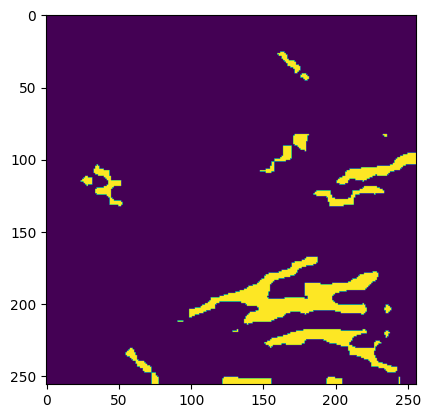

In [182]:
# im.show(masks[1])
plt.imshow(masks[2])
# len(masks)

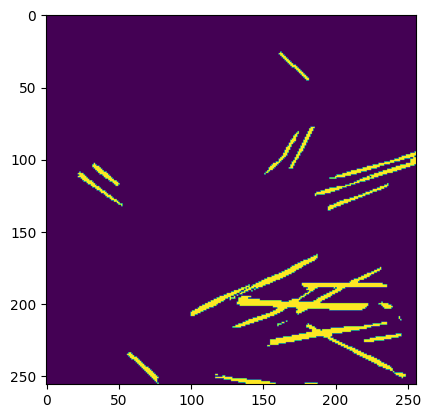

In [180]:
label = np.load(test_path + '8098169127491247044/human_pixel_masks.npy')
plt.imshow(label)

In [145]:
train_loss, val_loss = 0, 0
train_dice, val_dice = 0, 0
n_train, n_val = 0, 0

model.eval()
predictions = []
with torch.no_grad():
    for i_val, (X, y) in enumerate(test_loader):   
        # n_val += len(y)
        print(i_val)
        X = X.to(device)
        # y = y.to(device)

        pred = model(X)['out']
        predictions.append(pred)

        

0
1


In [147]:
predictions

[tensor([[[[ -9.4162,  -9.4162,  -9.4162,  ..., -10.4249, -10.4249, -10.4249],
           [ -9.4162,  -9.4162,  -9.4162,  ..., -10.4249, -10.4249, -10.4249],
           [ -9.4162,  -9.4162,  -9.4162,  ..., -10.4249, -10.4249, -10.4249],
           ...,
           [-10.0874, -10.0874, -10.0874,  ..., -10.0577, -10.0577, -10.0577],
           [-10.0874, -10.0874, -10.0874,  ..., -10.0577, -10.0577, -10.0577],
           [-10.0874, -10.0874, -10.0874,  ..., -10.0577, -10.0577, -10.0577]]]],
        device='cuda:0'),
 tensor([[[[ -8.0304,  -8.0304,  -8.0304,  ...,  -9.4765,  -9.4765,  -9.4765],
           [ -8.0304,  -8.0304,  -8.0304,  ...,  -9.4765,  -9.4765,  -9.4765],
           [ -8.0304,  -8.0304,  -8.0304,  ...,  -9.4765,  -9.4765,  -9.4765],
           ...,
           [-11.8439, -11.8439, -11.8439,  ..., -10.7291, -10.7291, -10.7291],
           [-11.8439, -11.8439, -11.8439,  ..., -10.7291, -10.7291, -10.7291],
           [-11.8439, -11.8439, -11.8439,  ..., -10.7291, -10.7291, -1

In [54]:
dir(test_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [52]:
predictions

[]

In [35]:
masks

[]